In [1]:
from __future__ import division
from refnx.analysis import abeles
import numpy as np
from scipy.signal import fftconvolve, convolve
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy.testing import assert_, assert_almost_equal

In [2]:
from matplotlib.pyplot import *

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20, 15)

In [3]:
moto = np.loadtxt("fit_theoretical.txt")
moto_x, moto_y = np.hsplit(moto, 2)
moto_x = moto_x.flatten()
moto_y = moto_y.flatten()

In [34]:
def res(qq, layer, resolution=5):
    resolution /= 100
    gaussnum = 51
    gaussgpoint = (gaussnum - 1) / 2
    gauss = (
        lambda x, s: 1.0
        / s
        / np.sqrt(2 * np.pi)
        * np.exp(-0.5 * x**2 / s / s)
    )

    lowQ = np.min(qq)
    highQ = np.max(qq)
    if lowQ <= 0:
        lowQ = 1e-6

    start = np.log10(lowQ) - 6 * resolution / 2.35482
    finish = np.log10(highQ * (1 + 6 * resolution / 2.35482))
    interpnum = np.round(
        np.abs(
            1
            * (np.abs(start - finish))
            / (1.7 * resolution / 2.35482 / gaussgpoint)
        )
    )
    xtemp = np.linspace(start, finish, interpnum)

    gauss_x = np.linspace(-1.7 * resolution, 1.7 * resolution, gaussnum)
    gauss_y = gauss(gauss_x, resolution / (2 * np.sqrt(2 * np.log(2))))
    xlin = np.power(10, xtemp)
    rvals = abeles(xlin, layer)
    smeared_rvals = convolve(rvals, gauss_y, mode="same")
    interpolator = InterpolatedUnivariateSpline(xlin, smeared_rvals, k=3)
    smeared_output = interpolator(qq)
    smeared_output /= np.sum(gauss_y)
    return smeared_output

In [35]:
resolution = 5.0
qq = np.linspace(0.005, 0.3, 1000)
layer = np.array([1, 1, 0, 0, 2.07, 0, 0, 3, 400, 3.47, 0, 3])

In [36]:
r = res(qq, layer, resolution=5.0)

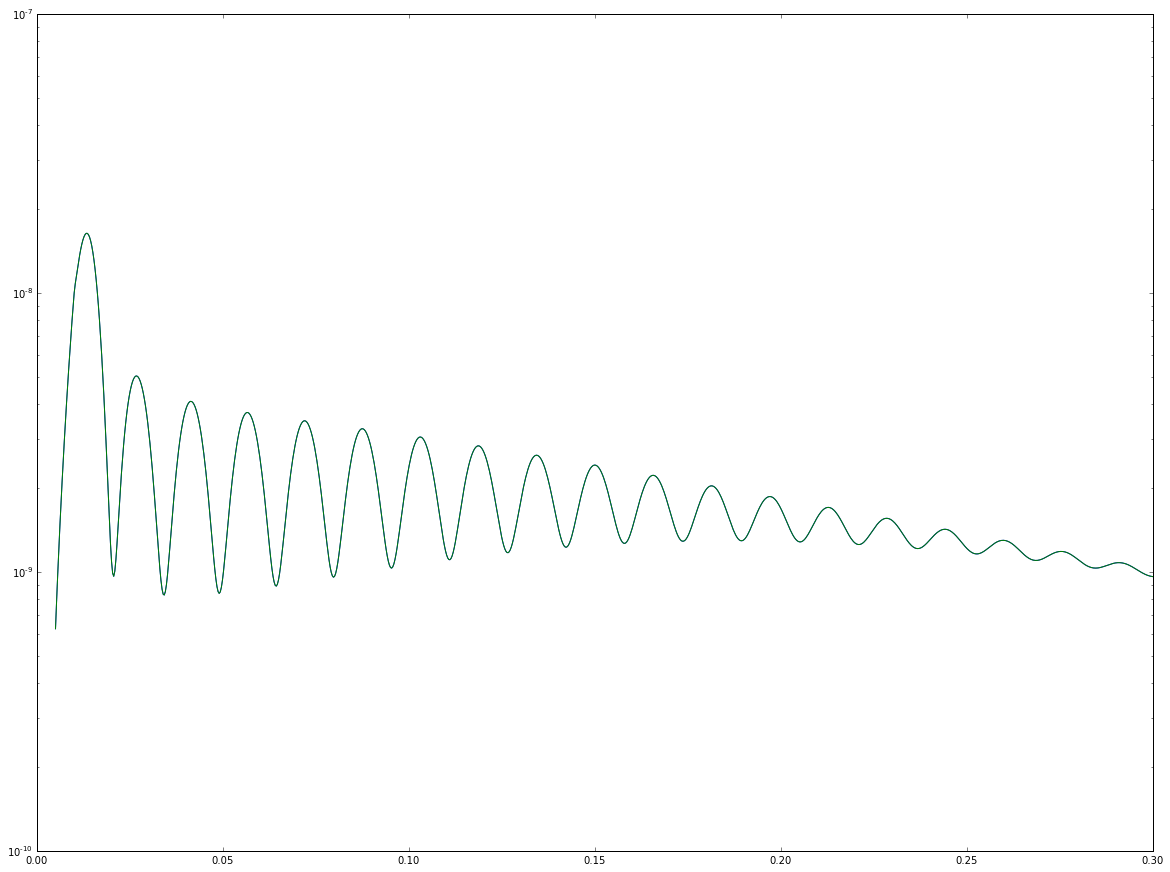

In [37]:
plot(moto_x, moto_y * moto_x**4, qq, r * qq**4)
yscale("log")

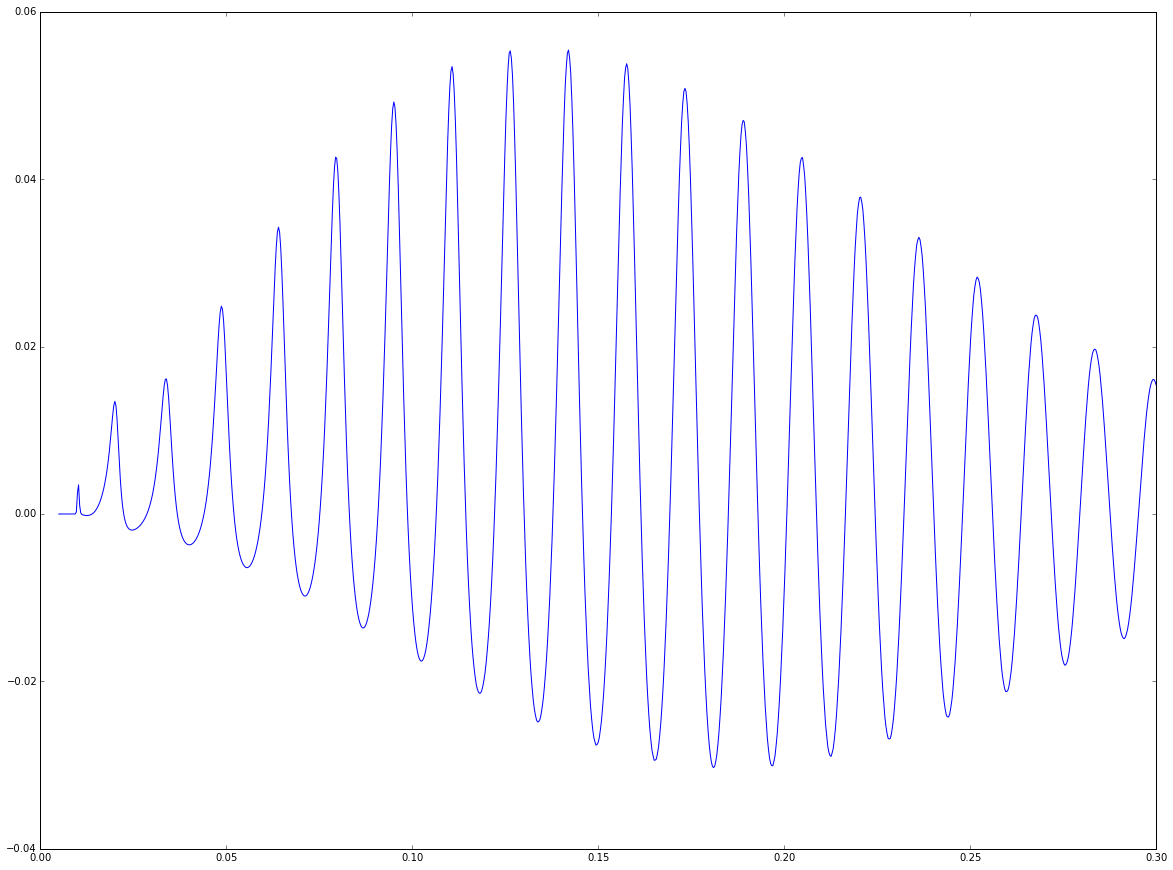

In [38]:
plot(moto_x, 100 * (r - moto_y) / r)

In [39]:
dqvals = 0.05 * qq
r_pointbypoint = abeles(qq, layer, dqvals=dqvals, quad_order=101)

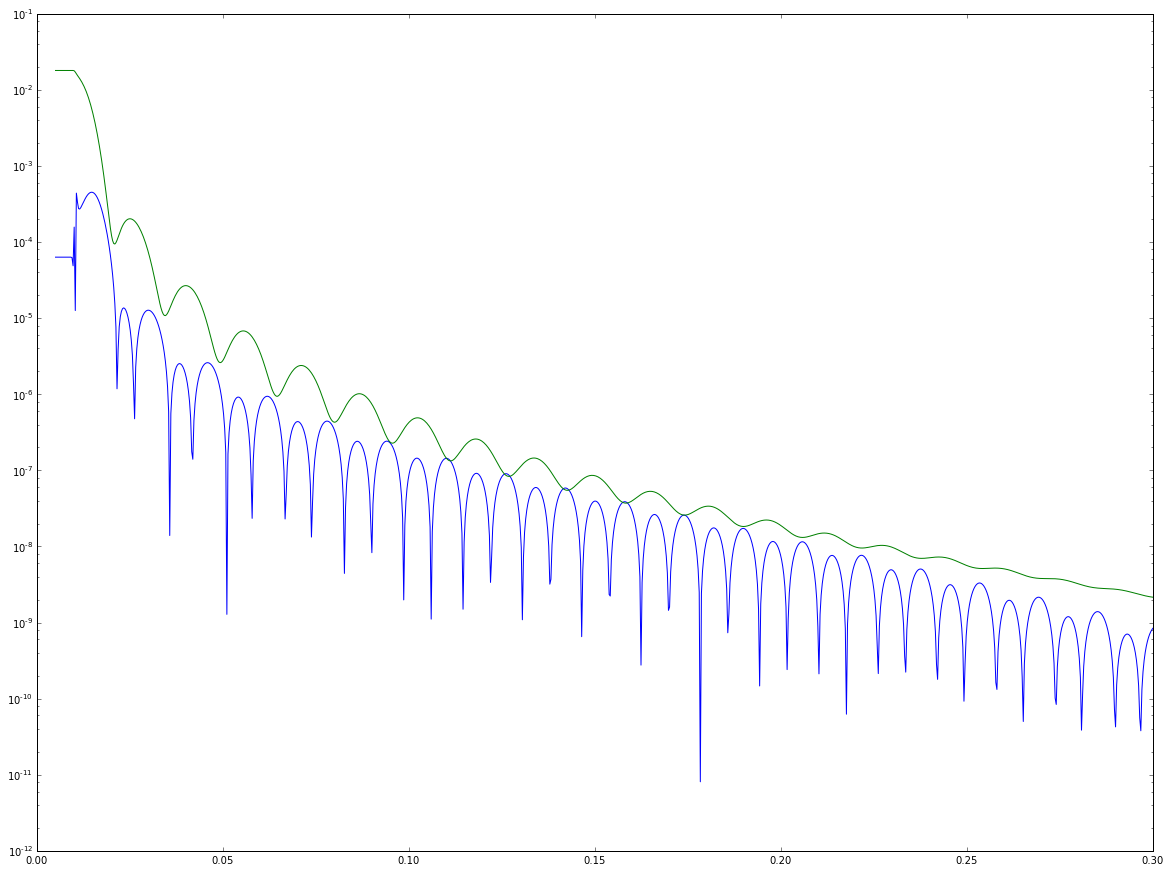

In [41]:
plot(qq, np.abs(r_pointbypoint - r), qq, 0.018 * r_pointbypoint)
yscale("log")

In [42]:
%timeit -n 1000 res(qq, layer)

1000 loops, best of 3: 1.62 ms per loop


In [43]:
%timeit abeles(qq, layer, dqvals=dqvals, quad_order=17)

100 loops, best of 3: 2.89 ms per loop


In [44]:
%timeit -n 1000 abeles(qq, layer)

1000 loops, best of 3: 223 µs per loop


In [46]:
np.allclose(r, r_pointbypoint, rtol=0.018)

True

In [47]:
np.allclose(r, r_pointbypoint, atol=1e-3)

True